# LSTM

In [1]:
# 预设置代码，当前d2l版本缺失某些东西
import torch
from d2l import torch as d2l
import math
from torch import nn
from torch.nn import functional as F
import collections
import random
import re


d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')


def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]



def seq_data_iter_random(corpus, batch_size, num_steps):
    corpus = corpus[random.randint(0, num_steps-1):]
    num_subseqs = (len(corpus) -1) // num_steps
    # initial_indices用于确定每个子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    random.shuffle(initial_indices)
    
    def data(pos):
        return corpus[pos:pos+num_steps]
    
    num_batchs = num_subseqs // batch_size
    
    for i in range(0, num_batchs * batch_size, batch_size):
        initial_indices_per_batch = initial_indices[i: i+batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j+1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)
    

def seq_data_iter_sequential(corpus, batch_size, num_steps):
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset+1: offset + num_tokens +1])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1, )
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

def tokenize(lines, token='word'):
    if token == 'word':
        # split() 默认以任意空白字符（空格、制表符等）分割
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

class Vocab:  #@save
    """
    文本词表类，用于将字符串词元和索引进行双向映射，同时计算和保存词频信息。

    参数:
        tokens: 用于构建词表的词元列表（可以是1D或2D）。
        min_freq: 包含进入词表的最低词频。
        reserved_tokens: 预留的特殊词元，如['<pad>']等。

    成员:
        idx_to_token: 存储每个索引对应的词元（列表）。
        token_to_idx: 存储每个词元对应的索引（字典）。
        _token_freqs: 存储每个词元及其对应词频（降序）。
    """
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:         # 如果没有提供tokens，默认为空列表
            tokens = []
        if reserved_tokens is None: # 如果没有提供预留词元，默认为空列表
            reserved_tokens = []
        # 1. 统计词频，结果是（词元, 词频）元组
        counter = count_corpus(tokens)
        # 2. 将词频结果按频率降序排序
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        # 3. 初始化词元到索引和索引到词元的映射。未知词元'<unk>'的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

        # 4. 添加满足最低词频的高频词元到词表映射中
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break      # 低于最低词频时停止添加
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        """返回词表中词元的数量"""
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        """
        支持用token或token的列表取索引（若为单token返回索引，列表则递归处理）
        未知词元将返回unk索引(通常为0)
        """
        if not isinstance(tokens, (list, tuple)):
            # 返回单个token的索引，若不存在则返回unk
            return self.token_to_idx.get(tokens, self.unk)
        # 对每个token递归取索引
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        """
        支持用索引或索引列表取词元
        """
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):
        """返回未知词元的索引，通常为0"""
        return 0

    @property
    def token_freqs(self):
        """返回(词元, 词频)的有序列表"""
        return self._token_freqs

def count_corpus(tokens):  #@save
    """
    统计语料中各词元的出现频率
    参数:
        tokens: 1D(词元列表)或2D(每行为词元列表的列表)
    返回:
        collections.Counter对象（词元到计数的映射）
    """
    # 若为2D列表则展开为1D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将每一行的词元合并到一个大列表中
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)  # 统计每个词元的出现次数

def load_corpus_time_machine(max_tokens=-1):
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

class SeqDataLoader:
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens) -> None:
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps
    
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_in = init_state, forward_fn
    
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_in(X, state, self.params)
    
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

def predict_ch8(prefix, num_preds, net, vocab, device):
    # 这里state的batch_size设为1，是因为我们在预测阶段是“逐步生成”下一个字符，
    # 每一次的输入都是上一时刻生成的单个字符（即batch只有1个样本，形状为(1,1)）。
    # 不是像训练时批量输入很多序列，而是每次生成只处理一条前缀并依次输出结果。
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    def get_input():
        return torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    # 用prefix对RNN进行“预热”，将state调整为看到prefix结尾的状态
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    # 逐步生成下一个字符，每次输入上一个预测结果
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

def clip_grad(net, theta):
    """
    该函数用于裁剪梯度防止梯度爆炸。
    如果梯度的L2范数大于阈值theta，则按比例缩小所有参数的梯度，保证所有参数的梯度L2范数不超过theta。
    参数：
        net: 神经网络模型，可以是nn.Module，也可以是自定义含有params属性的模型。
        theta: 阈值，梯度范数超过该值时触发裁剪。
    """
    if isinstance(net, nn.Module):
        # 取出需要梯度更新的参数
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        # 取自定义模型的参数
        params = net.params

    # 计算所有参数梯度的L2范数
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        # 逐个参数调整梯度，按比例缩小
        for param in params:
            param.grad[:] *= theta / norm

def train_epoch_ch8(net, train_iter, loss, updater, device, use_randow_iter):
    '''训练一个迭代周期'''
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X,y in train_iter:
        if state is None or use_randow_iter is True:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        # y.long()的意思是将张量y的数据类型转换为64位整型（long，即torch.int64）
        # 这是因为像CrossEntropyLoss等损失函数在PyTorch中要求目标张量为long型（类别标签需为整型）。
        # 这样可以确保损失函数计算时类型一致，避免类型不匹配的出错。
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
            updater.step()
        else:
            l.backward()
            d2l.grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        # 这样写是为了在从零实现RNN时，模型参数（net.params）是列表的形式而不是nn.Module的parameters，
        # 所以自定义一个用于小批量随机梯度下降的updater函数（此处是lambda表达式），
        # 每次将当前批量的batch_size传入d2l.sgd，配合学习率lr对参数进行原地更新。
        def updater(batch_size):
            return d2l.sgd(net.params, lr, batch_size)

    def predict(prefix):
        return predict_ch8(prefix, 50, net, vocab, device)
    
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter
        )
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs) -> None:
        super().__init__()
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens *2, self.vocab_size)
        
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state
    
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [3]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(shape, device=device) * 0.01
    
    def three():
        return (
            normal((num_inputs, num_hiddens)),
            normal((num_hiddens, num_hiddens)),
            torch.zeros(num_hiddens, device=device)
        )
    
    W_xi, W_hi, b_i = three()
    W_xf, W_hf, b_f = three()
    W_xo, W_ho, b_o = three()
    W_xc, W_hc, b_c = three()

    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    
    for param in params:
        param.requires_grad_(True)
    return params

In [4]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

In [5]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (
        torch.zeros((batch_size, num_hiddens), device=device),
        torch.zeros((batch_size, num_hiddens), device=device),
    )

困惑度 1.1, 64252.8 词元/秒 cpu
time traveller of thatthe remace whych lish le ag a willespatt a
travelleryou can show black is white by argument said filby


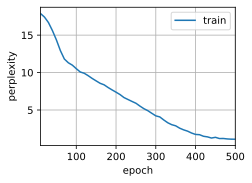

In [6]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = RNNModelScratch(vocab_size, num_hiddens, device, get_lstm_params, init_lstm_state, lstm)

train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [7]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_inputs = vocab_size
num_epochs, lr = 500, 1
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = RNNModel(lstm_layer, vocab_size)
model = model.to(device)

困惑度 1.0, 60255.5 词元/秒 cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


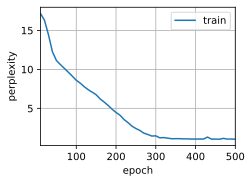

In [8]:
train_ch8(model, train_iter, vocab, lr, num_epochs, device)